In [57]:
import sys 
sys.path.append('..')

%load_ext autoreload
import torch
import matplotlib.pyplot as plt
from scipy import signal
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

from losses import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Input: 
	 torch.Size([1, 1, 28, 28]) 0.0 1.0


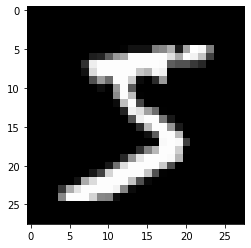

Target: 
	 torch.Size([1, 1, 28, 28]) 0.0 1.0


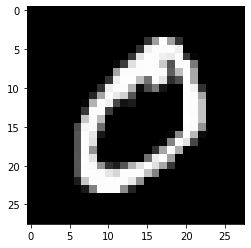

In [58]:
# Datasets and dataloaders
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
ds = MNIST("../notebooks/mnist_example/", download=False, train=True, transform=train_transform)


# train_transform = Compose([
#     Resize(28),
#     ToTensor(),
#     Grayscale(),
# ])
# ds = CIFAR10("../notebooks/cifar10_example/", download=False, train=True, transform=train_transform)

# Input example
input = ds[0][0].unsqueeze(0)
print("Input: \n\t", input.shape, input.min().item(), input.max().item())
plt.imshow(input.squeeze(0).squeeze(0), cmap="gray")
plt.show()

# Target example
target = ds[1][0].unsqueeze(0)
print("Target: \n\t", target.shape, target.min().item(), target.max().item())
plt.imshow(target.squeeze(0).squeeze(0), cmap="gray")
plt.show()

# Dimensions
h, w = input.shape[2], input.shape[3]


Filter size:  1567


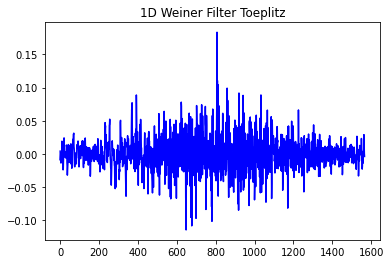

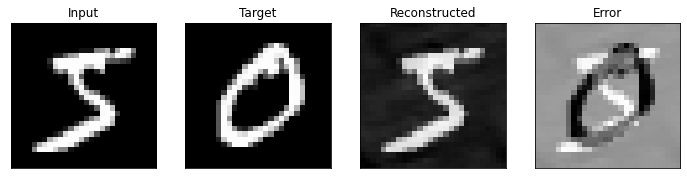

In [65]:
# 1D Weiner Filter using Toeplitz
aw1d = AWLoss1D(epsilon=3e-15, store_filters=True)
_ = aw1d(input, target)
vfilter = aw1d.v_all[0]
print("Filter size: ", len(vfilter))
plt.plot(vfilter, color="blue")
plt.title("1D Weiner Filter Toeplitz")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(target.flatten(start_dim=0), vfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

Filter size:  1567


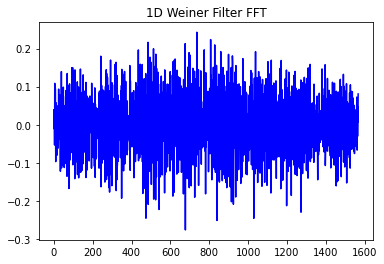

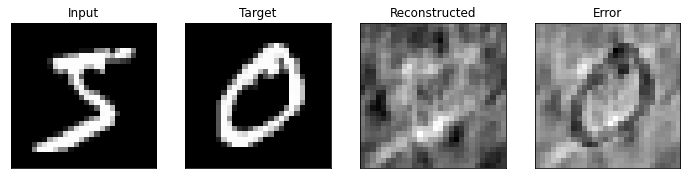

In [66]:
# 1D Weiner Filter using FFT
aw1dfft = AWLoss1DFFT(epsilon=3e-15, store_filters=True, filter_scale=2)
_ = aw1dfft(input, target)
wfilter = aw1dfft.v_all[0]
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner Filter FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)
# print(recon.shape)
# plt.plot(target.flatten(start_dim=0), label="target")
# plt.plot(input.flatten(start_dim=0), label="input")
# plt.plot(recon.flatten(), "--", label="recon")
# plt.show()

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

Filter size:  torch.Size([55, 55])


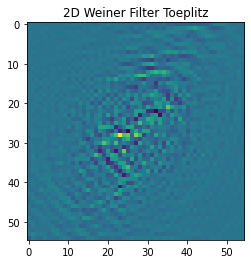

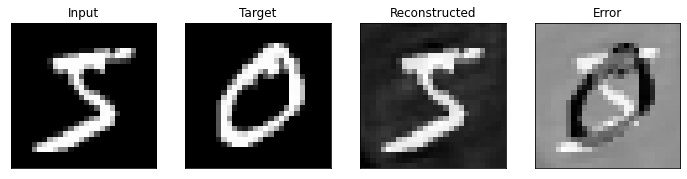

In [61]:
# 2D Weiner Filter using Toeplitz matrix
aw2d = AWLoss2D(epsilon=3e-15, store_filters=True)
_ = aw2d(input, target)
vfilter = aw2d.v_all[0]
print("Filter size: ", vfilter.shape)
plt.imshow(vfilter)
plt.title("2D Weiner Filter Toeplitz")
plt.show()


def get_middle_arr2d(img, shape):
    x_len, y_len = shape[0], shape[1]
    x_start = int(img.shape[0]/2) - int(x_len/2)
    y_start = int(img.shape[1]/2) - int(y_len/2)
    return img[x_start:x_start+x_len, y_start:y_start+y_len]

# Input convolved with filter (reconstructed target)
recon = signal.convolve2d(target.squeeze(0).squeeze(0), vfilter)
recon = get_middle_arr2d(recon, (h,w))

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

In [62]:
def wienerfft(x, y, prwh=3e-5):
    """
    calculates the optimal least squares convolutional Wiener filter that 
    transforms signal x into signal y
    """
    assert len(x.squeeze()) == len(y.squeeze()), "signals x and y must be the same length"
    Fccorr = torch.fft.fft(torch.flip(x, (0,1)))*torch.fft.fft(y) # cross-correlation of x with y 
    Facorr = torch.fft.fft(torch.flip(x, (0,1)))*torch.fft.fft(x) # auto-correlation of x
    Fdconv = Fccorr/(Facorr+torch.abs(Facorr).max()*prwh) # deconvolution of Fccorr by Facorr
    return torch.fft.irfft(Fdconv, len(x.squeeze())) # inverse Fourier transform

In [5]:
# 1D Weiner Filter using FFT

wfilter = wienerfft(input.flatten(start_dim=0), target.flatten(start_dim=0))
print("Filter size: ", len(wfilter))
plt.plot(wfilter, color="blue")
plt.title("1D Weiner FFT")
plt.show()


def get_middle_arr(arr, length):
    len_arr = len(arr)
    start = int(len_arr/2) - int(length/2)
    return arr[start:start+length]

# Input convolved with filter (reconstructed target)
recon = signal.convolve(input.flatten(start_dim=0), wfilter, mode="full")
recon = get_middle_arr(recon, h*w).reshape(h, w)

# Error
diff = recon - target.squeeze(0).squeeze(0).numpy()

# Plots
f, ax = plt.subplots(1,4, figsize=(12,5))
ax[0].imshow(input.squeeze(0).squeeze(0), cmap="gray")
ax[1].imshow(target.squeeze(0).squeeze(0), cmap="gray")
ax[2].imshow(recon, cmap="gray")
ax[3].imshow(diff, cmap="gray")

ax[0].title.set_text("Input")
ax[1].title.set_text("Target")
ax[2].title.set_text("Reconstructed")
ax[3].title.set_text("Error")
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
plt.show()

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

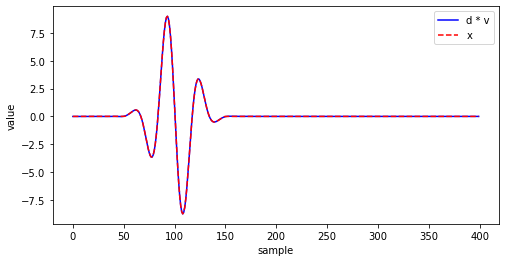

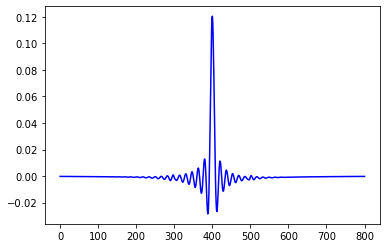

In [ ]:

v_FD = wienerfft(d_pad, x_pad)[:,:-(M-P)]


signal_plot(np.convolve(d, v_FD.squeeze())[x_pad_val:x_pad_val+N], x, 'd * v', 'x')

plt.plot(v_FD.squeeze(), color='blue')
plt.show()

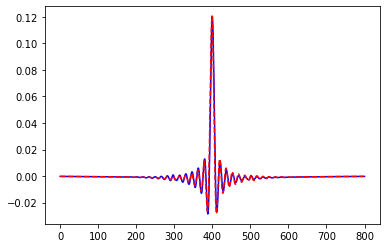

RuntimeError: The size of tensor a (799) must match the size of tensor b (801) at non-singleton dimension 1

In [ ]:
x, d = torch.from_numpy(x), torch.from_numpy(d)
x, d = x.unsqueeze(0).unsqueeze(0), d.unsqueeze(0).unsqueeze(0)

aw1dfft = AWLoss1DFFT(store_filters=True, epsilon=3e-5)
_ = aw1dfft(d, x)

plt.plot(v_FD.squeeze(), color='blue')
plt.plot(aw1dfft.v_all[0], "--", color="red")
plt.show()

print((aw1dfft.v_all[0] == v_FD).all())


In [ ]:
print((aw1dfft.v_all[0] == v_FD).all())

tensor(True)
